### This notebook was used for the results presented in [Thinking AIoud](https://thinking-ai-aloud.blogspot.com/2020/11/variational-autoencoders-vae-hands-on.html).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets
import torchvision.transforms as transforms

## Definitions

In [2]:
def one_hot(labels, n_classes=10):
    """Transforms integer labels to one-hot labels.
    
    Args:
      labels(int, iterable of ints): labels.
      n_classes(int): number of classes, default `10`.
    
    Returns:
      A torch.Tensor of the resulting one-hot encoding.
    """

    if isinstance(labels, int):
        labels = [labels]
    if not torch.is_tensor(labels):
        labels = torch.tensor(labels)
    if labels.dim() <= 1:
        labels = torch.zeros(labels.size(0), n_classes)\
            .scatter_(1, labels[..., None], 1)
    return labels

class View(nn.Module):
    """Simple module for reshaping.
    
    Attributes:
        shape(tuple): shape of the result.
    """
    
    def __init__(self, *shape):
        """Init.
        
        Args:
            shape(tuple): shape of the result.
        """
        super().__init__()
        self.shape = shape

    def forward(self, x):
        """View.
        
        Args:
            x(torch,Tensor): input.
            
        Returns:
            Reshaped `x`.
        """
        return x.view(*self.shape)


Here we define a VAE class. The encoder outputs the mean and the logarithm of the diagonal elements of the covariance matrix. The logarithm of the variance is chosen over the variance itself because we have to apply the exponential function to get the actual value we require, avoiding zero variance terms.

In [3]:
class VAE(nn.Module):
    """VAE for MNIST.

    Attributes:
        encoder(nn.Module): encodes features to concatenated
            mean and logarithm of variance.
        decoder(nn.Module): decodes latent variable to feature.
        conditional(bool): whether VAE is conditional.
        classes(int): number of classes.
        latent_dim(int): latent space dimension.
    """

    def __init__(self, latent_dim, layers, input_dims=(1, 28, 28),
                 actf=nn.ReLU(), n_classes=0):
        """Init.

        Args:
            latent_dim(int): dimensionality of latent variables.
            layers(list|int): hidden neurons of encoder
                and reverse for decoder.
            input_dims(tuple of ints): dimensions of input,
              default `(1, 28, 28)` for MNIST.
            actf(nn.Module): activation function,
              default `nn.LeakyReLU(0.2)`.
            n_classes(int): number of classes, default `0`
                (=> # classes is irrelevant => unconditional).
        """

        super().__init__()

        self.conditional = n_classes > 0
        self.classes = n_classes
        self.latent_dim = latent_dim

        if isinstance(layers, int):
            layers = [layers]

        channels, wdt, hgt = input_dims
        layers = [channels * wdt * hgt] + layers

        encoder = []
        decoder = []
        for in_feats, out_feats in zip(layers[:-1], layers[1:]):
            encoder.append(
                nn.Sequential(
                    nn.Linear(in_feats if encoder else in_feats + n_classes, out_feats),
                    actf
                )
            )
            decoder.append(
                nn.Sequential(
                    actf,
                    nn.Linear(out_feats, in_feats),
                )
            )

        self.encoder = nn.Sequential(
            *encoder,
            nn.Linear(layers[-1], 2 * latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + n_classes, layers[-1]),
            *list(reversed(decoder)),
            nn.Sigmoid(),
            View(-1, channels, wdt, hgt),
        )

    def forward(self, x, y=None):
        """Forward propagation.

        Args:
            x(torch.Tensor): input feature.
            y(torch.Tensor, None): conditioning variable,
                default `None`.

        Returns:
            The reconstruction of `x`, the mean of the latent
            variable and the logarithm of its variance.
        """
        latent_code, mean, logvar = self.encode(x, y)
        x_hat = self.decode(latent_code, y)
        return x_hat, mean, logvar

    def decode(self, code, cvar=None):
        """Decodes latent variable and conditioning variable.

        Args:
            code(torch.Tensor): latent variable.
            cvar(torch.Tensor, None): conditioning variable,
                default `None`.

        Returns:
            The reconstructed sample.
        """
        if self.conditional:
            code = torch.cat((code, one_hot(cvar, self.classes)), dim=-1)
        x = self.decoder(code)
        return x

    def encode(self, sample, cvar=None):
        """Encodes input.

        Args:
            sample(torch.Tensor): input to be encoded.

        Returns:
            The latent variable, its mean and the logarithm
            of its variance.
        """
        sample = torch.flatten(sample, start_dim=1)
        if self.conditional:
            sample = torch.cat((sample, one_hot(cvar, self.classes)), dim=-1)
        latent_stats = self.encoder(sample)
        split_dim = latent_stats.size(1) // 2
        mean, logvar = latent_stats[:, :split_dim], latent_stats[:, split_dim:]
        latent_code = mean + torch.empty_like(logvar).normal_() * (logvar / 2).exp()
        return latent_code, mean, logvar

In [4]:
def kl_divergence(mus, logvars):
    """Computes KL divergence of N(mus, e^{logvar/2}) from N(0, I).

    Args:
        mus(torch.Tensor): size (batch_size, cond_dim) with the means.
        logvars(torch.Tensor): size (batch_size, cond_dim) with the
            logarithm of the std devs.

    Returns:
        Loss.
    """

    return 0.5 * (logvars.exp().sum(dim=-1) + (mus ** 2).sum(dim=-1)
                  - logvars.sum(dim=-1) - mus.size(-1)).mean()

# L_{REC}
rec_criterion = lambda pred, tar: nn.BCELoss(reduction='sum')(pred, tar) / pred.size(0)


In [5]:
### LOAD MNIST

batch_size = 64
transform = transforms.ToTensor()
num_workers = 0

train_data = datasets.MNIST(root='data', train=True,
                            download=True, transform=transform)

test_data = datasets.MNIST(root='data', train=False,
                           download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          num_workers=num_workers)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
def train(vae, lr, epochs, train_dl, print_interval=0.05, device='cpu'):
    """Trains VAE.
    
    Args:
        vae(VAE): VAE.
        lr(float): learning rate.
        epochs(int): # epochs.
        train_dl(DataLoader): DataLoader to train on.
        print_interval(float): interval of printing loss as
            a ratio of total batches.
        device(str): device to run on.
    """
    
    vae.to(device)
    optimizer = optim.Adam(vae.parameters(), lr)

    for ep in range(epochs):
        print('Epoch {}'.format(ep + 1))
        for i, (x, y) in enumerate(train_dl):
            x, y = x.to(device), y.to(device)
            x_hat, m, logv = vae(x, y)
            loss = rec_criterion(x_hat, x) + kl_divergence(m, logv)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % int(print_interval * len(train_dl) - 1) == 0:
                print('\tBatch {} Loss: {:.3f}'.format(i+1, loss.item()))

In [7]:
def test(vae, test_dl, device='cpu'):
    """Tests reconstruction accuracy.
    
    Args:
        vae(VAE): VAE.
        test_dl(DataLoader): DataLoader to test on.
        device(str): device to run on.    
    """

    vae.to(device)
    eval_loss = 0
    for x, y in test_dl:
        x = x.to(device)
        y = torch.zeros_like(y, device=device)
        x_hat, m, logv = vae(x, y)
        eval_loss += rec_criterion(x_hat, x).item() * len(x)
    return eval_loss / len(test_dl.dataset)

In [22]:
def visual_eval(vae, dataset=None, generations=15, reconstructions=10, per_row=5, filename=None):
    """Plots generated and reconstructed samples.

    Args:
        vae(VAE): VAE.
        dataset(Dataset, None): dataset to sample from,
            default `None`. Must be set when
            `reconstructions > 0`
        generations(int): number of generated samples.
            If not multiple of `per_row`, it rounds down
            to its greatest possible multiple.
        reconstructions(int): number of samples to
            reconstruct.
        per_row(int): samples per row in plot.
        filename(str, dict, None): filename to save plots.
            Must be dict with `'generations'`, `'recontructions'`
            keys if both `generations > 0` and
            `reconstructions > 0`, else can be `str`.
            Default `None` (not saved).
    """

    if filename is not None and generations * reconstructions == 0:
        if generations > 0:
            filename = dict(generations=filename)
        else:
            filename = dict(reconstructions=filename)

    if generations > 0:
        ### GENERATE SAMPLES

        generations = max(per_row, generations)  # else fails

        labels = torch.arange(0, min(generations, 10))

        if generations > 10:
            labels1 = torch.repeat_interleave(labels[:generations % 10], generations // 10 + 1)
            labels2 = torch.repeat_interleave(labels[generations % 10:], generations // 10)
            labels = torch.cat((labels1, labels2))

        images = vae.decode(torch.randn(generations, vae.latent_dim),
                            one_hot(labels))
        fg, axs = plt.subplots(nrows=generations // per_row, ncols=per_row,
                               **{'figsize': (3 * per_row, 2.5 * generations / per_row)})
        fg.suptitle('Random Samples', bbox=dict(facecolor='red', alpha=0.5), fontsize=20)

        for i in range(generations):
            try:
                axs[i // per_row, i % per_row].imshow(images[i].detach().numpy().squeeze(), cmap='binary')
                axs[i // per_row, i % per_row].set_axis_off()
                if vae.conditional:
                  axs[i // per_row, i % per_row].text(0, 0, 'cond_var={}'.format(labels[i].item()),
                                          bbox=dict(facecolor='purple', alpha=0.9))
            except IndexError:
                axs[i % per_row].imshow(images[i].detach().numpy().squeeze(), cmap='binary')
                axs[i % per_row].set_axis_off()
                axs[i % per_row].text(0, 27, 'cond_var={}'.format(labels[i].item()),
                            bbox=dict(facecolor='purple', alpha=0.9))

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        if filename is not None:
            fg.savefig(filename['generations'], transparent=True)

    if reconstructions > 0:
        # RECONSTRUCT SAMPLES

        fg, axs = plt.subplots(nrows=reconstructions, ncols=2,
                               **{'figsize': (5, 2.5 * reconstructions)})
        fg.suptitle('Reconstructed Samples', bbox=dict(facecolor='red', alpha=0.5), fontsize=20)

        for i in range(reconstructions):
            inp, lbl = dataset[torch.randint(len(dataset), (1,))[0]]
            image = vae(inp[None, ...], lbl)[0]
            axs[i, 0].imshow(inp.squeeze(), cmap='binary')
            axs[i, 1].imshow(image.detach().numpy().squeeze(), cmap='binary')
            axs[i, 0].set_axis_off()
            axs[i, 1].set_axis_off()
            axs[i, 0].set_title('Original', bbox=dict(facecolor='purple', alpha=0.9))
            axs[i, 1].set_title('Reconstructed', bbox=dict(facecolor='purple', alpha=0.9))
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        if filename is not None:
            fg.savefig(filename['reconstructions'], transparent=True)

In [16]:
def latent_space(vae, dataset, per_class=100, filename=None, **kwargs):
    """Plots latent space.

    Args:
        vae(VAE): VAE.
        dataset(Dataset): dataset to sample from.
        per_class(int): number of samples to use to
            estimate Gaussian.
        filename(str, None): filename to save plot,
            default `None` (not saved).
        kwargs(optional):
            minC(float): minimum value of exponent
                of Gaussian used to calculate contour.
            maxC(float): maximum value of exponent
                of Gaussian used to calculate contour.
            n_contours(int): number of countours.
            xmin, xmax, ymin, ymax: plot limits.
            scatter(bool): whether to plot scatter
                of sampled laten space points.
            ellipses(bool): whether to plot contours.
    """
    if vae.latent_dim != 2:
        return

    # contours of equal probability
    minC = kwargs.get('minC', 4)
    maxC = kwargs.get('maxC', 70)
    n_contours = kwargs.get('n_contours', 7)

    scatter, ellipses = kwargs.get('scatter', True), kwargs.get('ellipses', True)
    plots = int(scatter) + int(ellipses)  # 2 if both set

    fg, axs = plt.subplots(ncols=plots, figsize=(12.5 * plots, 12), sharex=True, sharey=True)
    fg.subplots_adjust(top=0.95)
    
    xmin, ymin = kwargs.get('xmin', -4), kwargs.get('ymin', -4)
    xmax, ymax = kwargs.get('xmax', 4), kwargs.get('ymax', 4)

    # print x, y axis
    if plots == 2:
        axs[0].axhline(y=0, color='lightgray')
        axs[0].axvline(x=0, color='lightgray')
        axs[1].axhline(y=0, color='lightgray')
        axs[1].axvline(x=0, color='lightgray')
        axs[0].set_xlim([xmin,xmax])
        axs[0].set_ylim([ymin,ymax])
        axs[1].set_xlim([xmin,xmax])
        axs[1].set_ylim([ymin,ymax])
    else:
        axs.axhline(y=0, color='lightgray')
        axs.axvline(x=0, color='lightgray')
        axs.set_xlim([xmin,xmax])
        axs.set_ylim([ymin,ymax])

    # sample digits for each class
    samples = {i: [] for i in range(10)}
    for i in torch.randperm(len(dataset)):
        image, label = dataset[i]
        if len(samples[label]) < per_class:
            samples[label].append(image)

        if all([len(cls_samples) == per_class for
                cls_samples in samples.values()]):
            break

    fg.suptitle('Latent Space', fontsize=30)
    cm = plt.cm.rainbow(np.linspace(0, 1, 10))

    for label in samples:
        latent_vars, means, logvars = vae.encode(torch.stack(samples[label]),
                                                 per_class * [label])
        latent_vars = latent_vars.detach().numpy()
        mean = means.mean(dim=0).detach().numpy()
        var = (logvars / 2).exp().mean(dim=0).detach().numpy() ** 2

        x = latent_vars[:, 0]
        y = latent_vars[:, 1]

        if scatter:
            if plots == 2:
                axs[0].scatter(x, y, c=[cm[label]], label=label)
            else:
                axs.scatter(x, y, c=[cm[label]], label=label)


        if ellipses:
            for i, C in enumerate(np.linspace(minC, maxC, n_contours)):
                x0 = np.linspace(mean[0] - (var[0] * C) ** 0.5, mean[0] + (var[0] * C) ** 0.5, 2000)
                # x0[1:-1] because floating point approxs cause nagative values in sqrt
                x1_pos = [mean[1]] + list((mean[1] + (var[1] * C - ((var[1] / var[0]) * (x0[1:-1] - mean[0]) ** 2)) ** 0.5)) + [mean[1]]
                x1_neg = [mean[1]] + list((mean[1] - (var[1] * C - ((var[1] / var[0]) * (x0[1:-1] - mean[0]) ** 2)) ** 0.5)) + [mean[1]]
                if plots == 2:
                    axs[1].plot(x0, x1_pos, c=cm[label])
                    axs[1].scatter(mean[0], mean[1], c=[cm[label]])
                    axs[1].plot(x0, x1_neg, c=cm[label])
                else:
                    if i == 0:
                        # else shows same label multiple times
                        axs.plot(x0, x1_pos, c=cm[label], label=label)
                    else:
                        axs.plot(x0, x1_pos, c=cm[label])
                    axs.scatter(mean[0], mean[1], c=[cm[label]])
                    axs.plot(x0, x1_neg, c=cm[label])
    
    if plots == 2:
        handles, labels = axs[0].get_legend_handles_labels()
        fg.legend(handles, labels, fontsize=20)
    else:
        plt.legend(fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if filename is not None:
        fg.savefig(filename)

In [15]:
def digit_grid(vae, digit, dataset, side=9, per_class=100, filename=None, normalize=False):
    """Plots images generated from codes arranged in a grid.

    Args:
        vae(VAE): VAE.
        digit(int): digit to generate for.
        dataset(Dataset): dataset to sample from.
        sides(int): how many samples in x, y direction.
        per_class(int): how many samples to use per
            class to estimate values.
        filename(str, None): filename to save plot,
            default `None` (not saved).
        normalize(bool): normalize width (default [-2, 2])
            based on estimated std dev, default `False`.
    """

    x0, x1 = np.meshgrid(np.linspace(-2, 2, side), np.linspace(-2, 2, side))
    if not vae.conditional:
        samples = []
        for i in torch.randperm(len(dataset)):
            image, label = dataset[i]
            
            if not label == digit:
                continue
            
            samples.append(image)
            
            if len(samples) == per_class:
                break

        _, means, logvars = vae.encode(torch.stack(samples),
                                       per_class * [digit])
        mean = means.mean(dim=0).detach().numpy()
        std = (logvars / 2).exp().mean(dim=0).detach().numpy()

        x0 = x0 * (std[0] if normalize else 1) + mean[0]
        x1 = x1 * (std[1] if normalize else 1) + mean[1]

    x0 = x0.flatten().astype(np.float32)
    x1 = x1.flatten().astype(np.float32)
    latent_vars = torch.from_numpy(np.stack((x0, x1), axis=1))
    images = vae.decode(latent_vars, latent_vars.size(0) * [digit]
    )
    images = images.detach().numpy().squeeze()

    fg, axs = plt.subplots(nrows=side, ncols=side, **{'figsize': (1.5 * side,)*2})
    fg.suptitle('{}\'s {}VAE 2D Grid'.format(digit, 'C' if vae.conditional else ''),
                bbox=dict(facecolor='red', alpha=0.5), fontsize=20)

    for x in range(side):
      for y in range(side):
          axs[side-1-y, x].imshow(images[x + side * y], cmap='binary')
          axs[side-1-y, x].set_axis_off()
          axs[side-1-y, x].text(0, 0, '({:.2f}, {:.2f})'.format(x0[x + side * y], x1[x + side * y]),
                          bbox=dict(facecolor='purple', alpha=0.9), fontsize=8)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if filename is not None:
        fg.savefig(filename, transparent=True)


## Training

In [8]:
vae = VAE(2, [2**8])
train(vae, 1e-3, 15, train_loader, print_interval=1)

Epoch 1
	Batch 1 Loss: 549.844
	Batch 938 Loss: 179.249
Epoch 2
	Batch 1 Loss: 166.120
	Batch 938 Loss: 174.467
Epoch 3
	Batch 1 Loss: 161.541
	Batch 938 Loss: 174.038
Epoch 4
	Batch 1 Loss: 158.858
	Batch 938 Loss: 170.811
Epoch 5
	Batch 1 Loss: 155.901
	Batch 938 Loss: 169.128
Epoch 6
	Batch 1 Loss: 154.752
	Batch 938 Loss: 168.838
Epoch 7
	Batch 1 Loss: 152.656
	Batch 938 Loss: 167.031
Epoch 8
	Batch 1 Loss: 151.669
	Batch 938 Loss: 164.854
Epoch 9
	Batch 1 Loss: 150.358
	Batch 938 Loss: 161.848
Epoch 10
	Batch 1 Loss: 149.455
	Batch 938 Loss: 162.278
Epoch 11
	Batch 1 Loss: 149.563
	Batch 938 Loss: 160.343
Epoch 12
	Batch 1 Loss: 149.632
	Batch 938 Loss: 158.343
Epoch 13
	Batch 1 Loss: 147.305
	Batch 938 Loss: 157.197
Epoch 14
	Batch 1 Loss: 146.247
	Batch 938 Loss: 156.759
Epoch 15
	Batch 1 Loss: 146.313
	Batch 938 Loss: 155.209


In [9]:
vae5 = VAE(5, [2**8])
train(vae5, 1e-3, 10, train_loader, print_interval=1)

Epoch 1
	Batch 1 Loss: 551.743
	Batch 938 Loss: 147.330
Epoch 2
	Batch 1 Loss: 136.403
	Batch 938 Loss: 140.426
Epoch 3
	Batch 1 Loss: 131.849
	Batch 938 Loss: 136.872
Epoch 4
	Batch 1 Loss: 129.261
	Batch 938 Loss: 134.892
Epoch 5
	Batch 1 Loss: 128.123
	Batch 938 Loss: 132.168
Epoch 6
	Batch 1 Loss: 125.513
	Batch 938 Loss: 130.472
Epoch 7
	Batch 1 Loss: 125.780
	Batch 938 Loss: 129.043
Epoch 8
	Batch 1 Loss: 123.886
	Batch 938 Loss: 127.997
Epoch 9
	Batch 1 Loss: 123.515
	Batch 938 Loss: 128.489
Epoch 10
	Batch 1 Loss: 123.599
	Batch 938 Loss: 127.450


In [10]:
vae10 = VAE(10, [2**8])
train(vae10, 1e-3, 10, train_loader, print_interval=1)

Epoch 1
	Batch 1 Loss: 546.366
	Batch 938 Loss: 135.984
Epoch 2
	Batch 1 Loss: 126.399
	Batch 938 Loss: 129.843
Epoch 3
	Batch 1 Loss: 121.934
	Batch 938 Loss: 124.747
Epoch 4
	Batch 1 Loss: 116.836
	Batch 938 Loss: 123.195
Epoch 5
	Batch 1 Loss: 116.562
	Batch 938 Loss: 120.667
Epoch 6
	Batch 1 Loss: 112.977
	Batch 938 Loss: 119.890
Epoch 7
	Batch 1 Loss: 112.282
	Batch 938 Loss: 119.605
Epoch 8
	Batch 1 Loss: 111.864
	Batch 938 Loss: 117.944
Epoch 9
	Batch 1 Loss: 111.393
	Batch 938 Loss: 118.353
Epoch 10
	Batch 1 Loss: 110.765
	Batch 938 Loss: 116.774


In [11]:
cvae = VAE(2, [2**8], n_classes=10)
train(cvae, 1e-3, 15, train_loader, print_interval=1)

Epoch 1
	Batch 1 Loss: 543.354
	Batch 938 Loss: 150.337
Epoch 2
	Batch 1 Loss: 144.116
	Batch 938 Loss: 142.751
Epoch 3
	Batch 1 Loss: 138.644
	Batch 938 Loss: 136.115
Epoch 4
	Batch 1 Loss: 135.093
	Batch 938 Loss: 133.537
Epoch 5
	Batch 1 Loss: 133.936
	Batch 938 Loss: 131.731
Epoch 6
	Batch 1 Loss: 133.149
	Batch 938 Loss: 130.623
Epoch 7
	Batch 1 Loss: 130.919
	Batch 938 Loss: 129.279
Epoch 8
	Batch 1 Loss: 130.849
	Batch 938 Loss: 128.463
Epoch 9
	Batch 1 Loss: 129.430
	Batch 938 Loss: 129.605
Epoch 10
	Batch 1 Loss: 129.002
	Batch 938 Loss: 128.359
Epoch 11
	Batch 1 Loss: 129.194
	Batch 938 Loss: 128.110
Epoch 12
	Batch 1 Loss: 128.862
	Batch 938 Loss: 127.118
Epoch 13
	Batch 1 Loss: 128.538
	Batch 938 Loss: 127.222
Epoch 14
	Batch 1 Loss: 127.915
	Batch 938 Loss: 126.964
Epoch 15
	Batch 1 Loss: 128.366
	Batch 938 Loss: 126.618


In [12]:
cvae5 = VAE(5, [2**8], n_classes=10)
train(cvae5, 1e-3, 10, train_loader, print_interval=1)

Epoch 1
	Batch 1 Loss: 543.943
	Batch 938 Loss: 136.652
Epoch 2
	Batch 1 Loss: 130.609
	Batch 938 Loss: 127.873
Epoch 3
	Batch 1 Loss: 124.069
	Batch 938 Loss: 124.123
Epoch 4
	Batch 1 Loss: 122.925
	Batch 938 Loss: 122.434
Epoch 5
	Batch 1 Loss: 119.399
	Batch 938 Loss: 120.718
Epoch 6
	Batch 1 Loss: 118.161
	Batch 938 Loss: 120.266
Epoch 7
	Batch 1 Loss: 117.712
	Batch 938 Loss: 118.774
Epoch 8
	Batch 1 Loss: 115.737
	Batch 938 Loss: 117.864
Epoch 9
	Batch 1 Loss: 114.495
	Batch 938 Loss: 117.150
Epoch 10
	Batch 1 Loss: 113.278
	Batch 938 Loss: 117.275


## Experiments

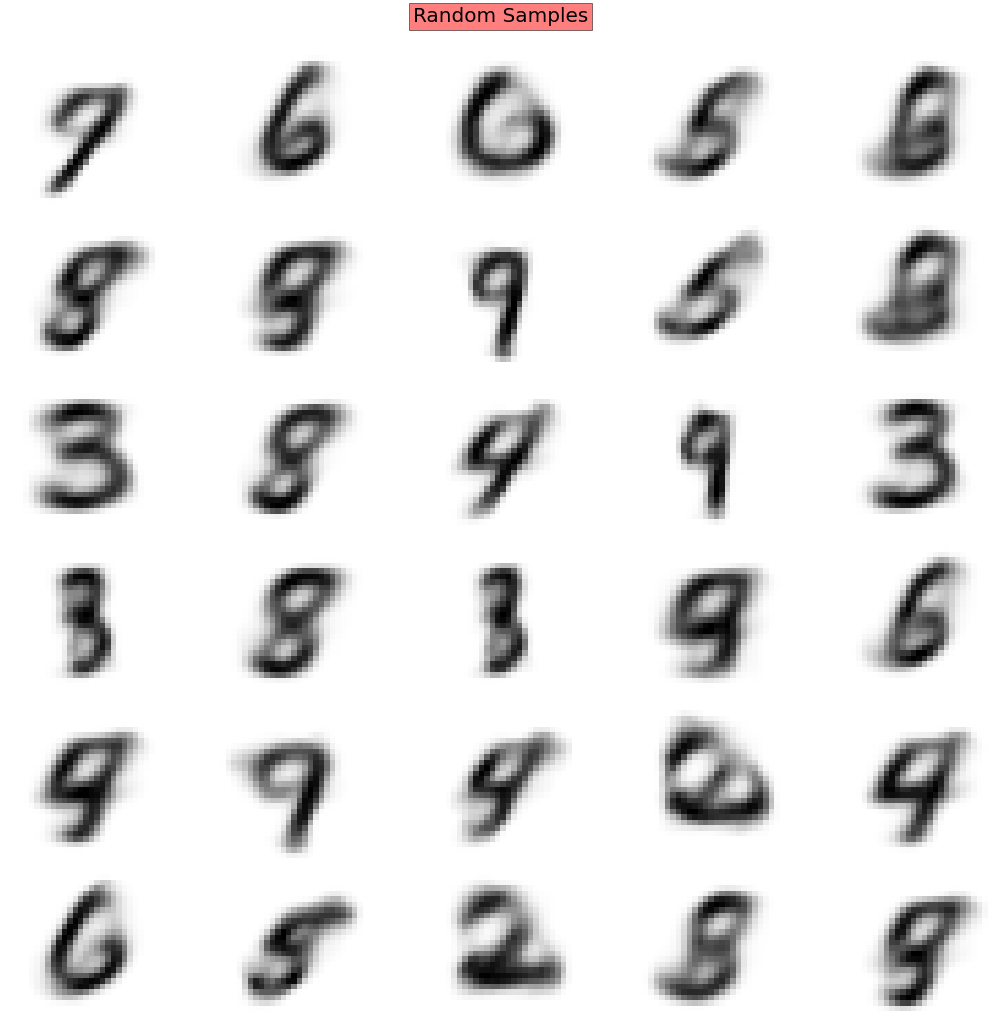

In [19]:
visual_eval(vae, generations=30, per_row=5, reconstructions=0, filename='vae2_samples.png')

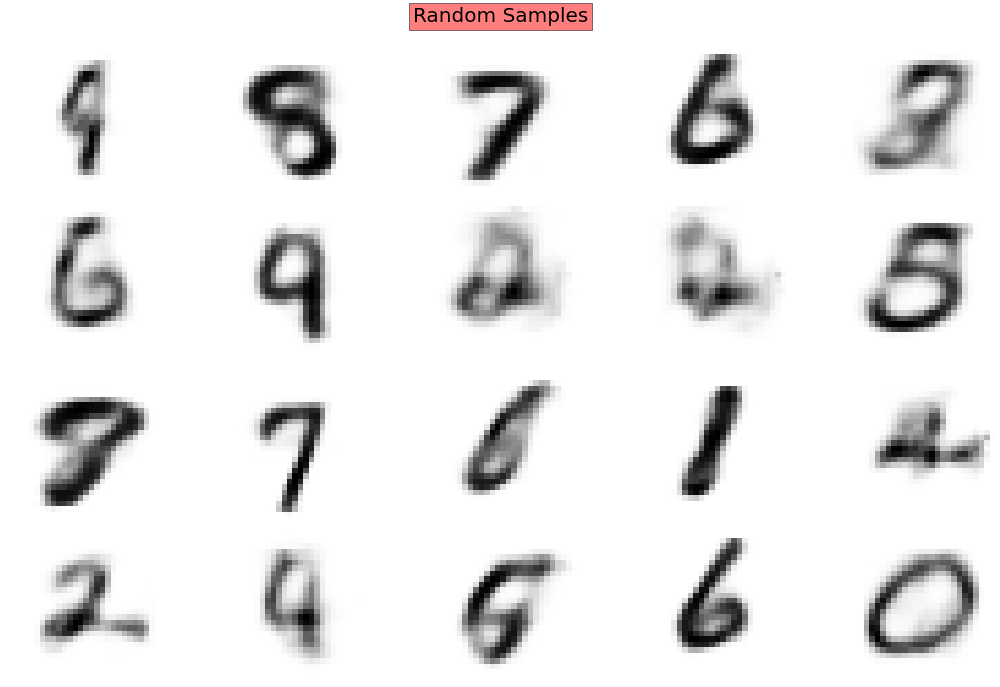

In [24]:
visual_eval(vae5, train_loader, generations=20, per_row=5, reconstructions=0, filename='vae5_samples.png')

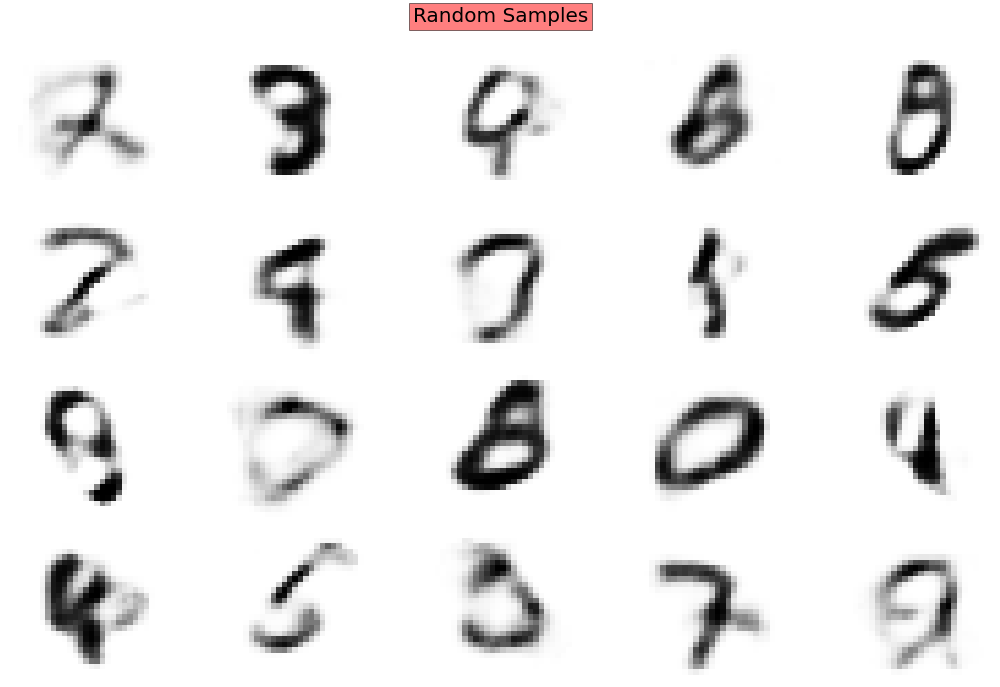

In [25]:
visual_eval(vae10, train_loader, generations=20, per_row=5, reconstructions=0, filename='vae10_samples.png')

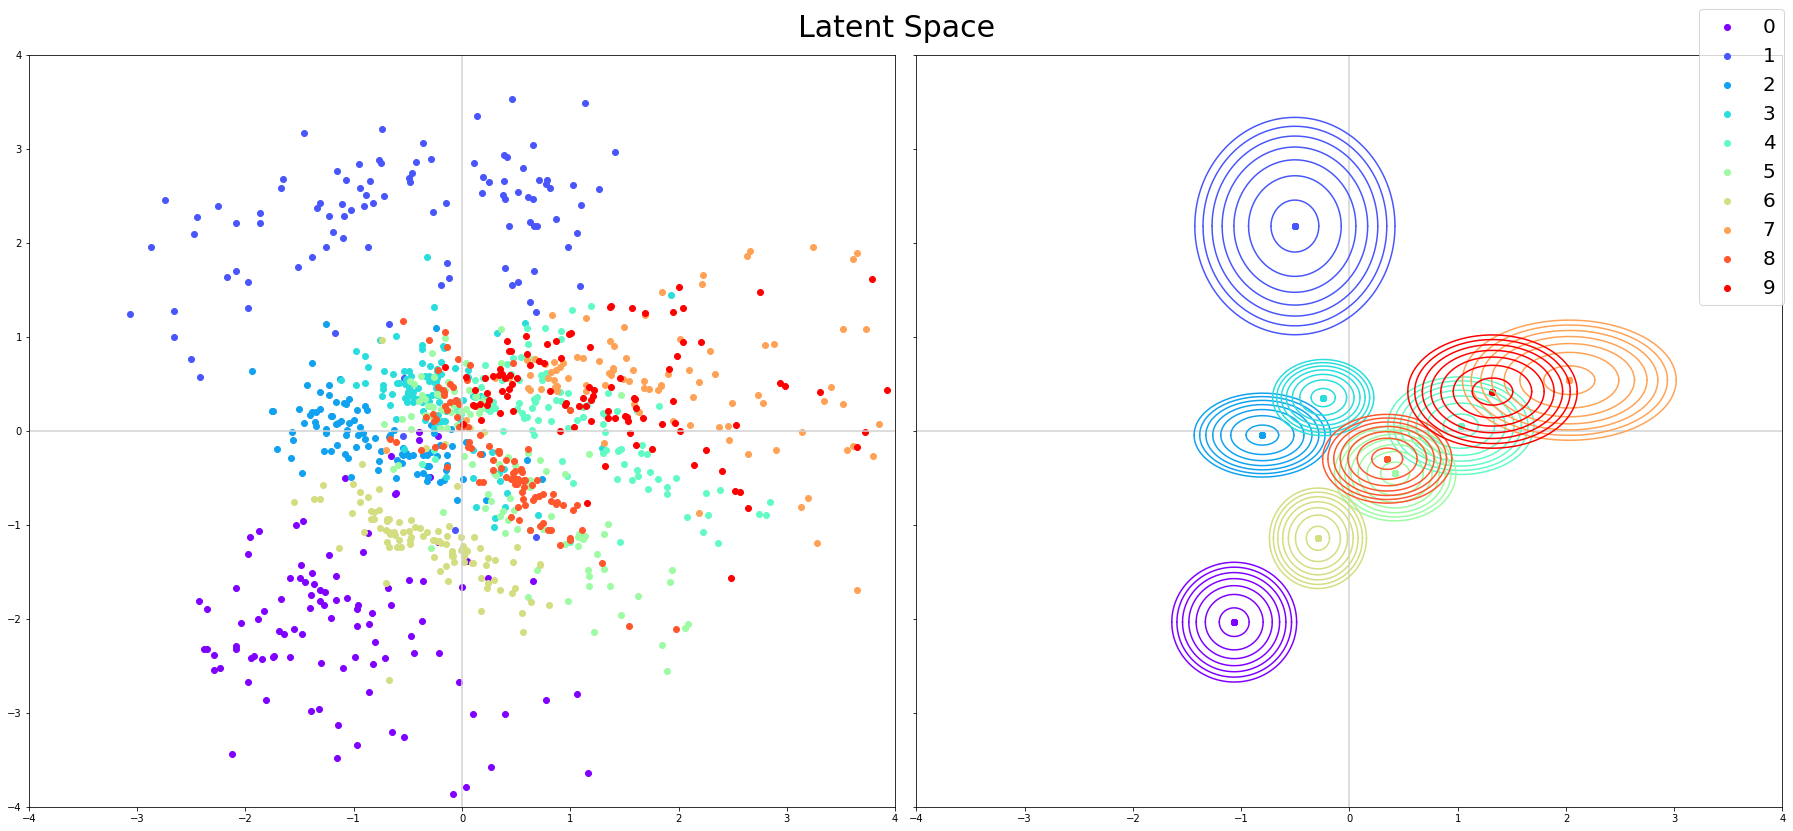

In [17]:
latent_space(vae, train_data, 100, 'train_latent_space.png')

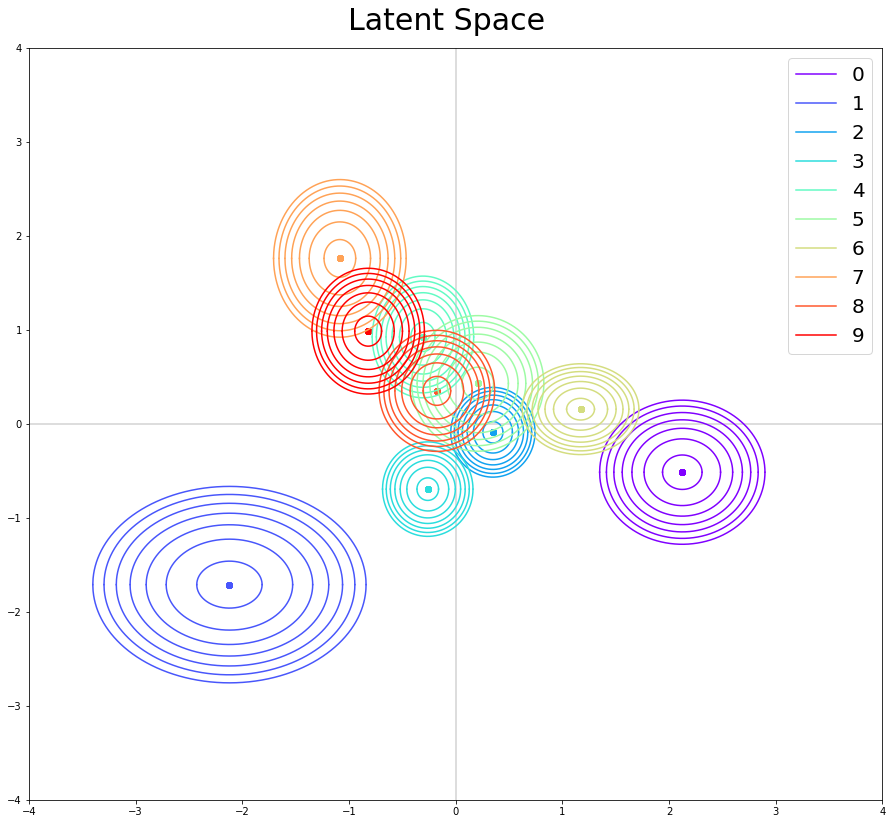

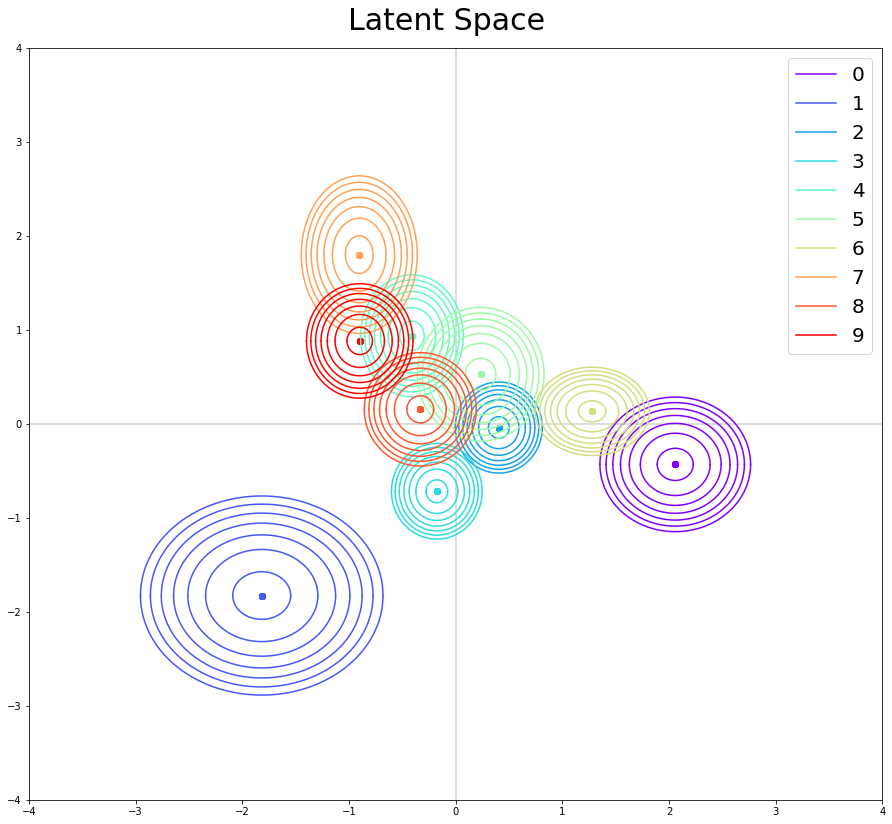

In [19]:
latent_space(vae, train_data, 100, 'train_distributions.png', scatter=False)
latent_space(vae, train_data, 100, 'train_distributions_alt.png', scatter=False)

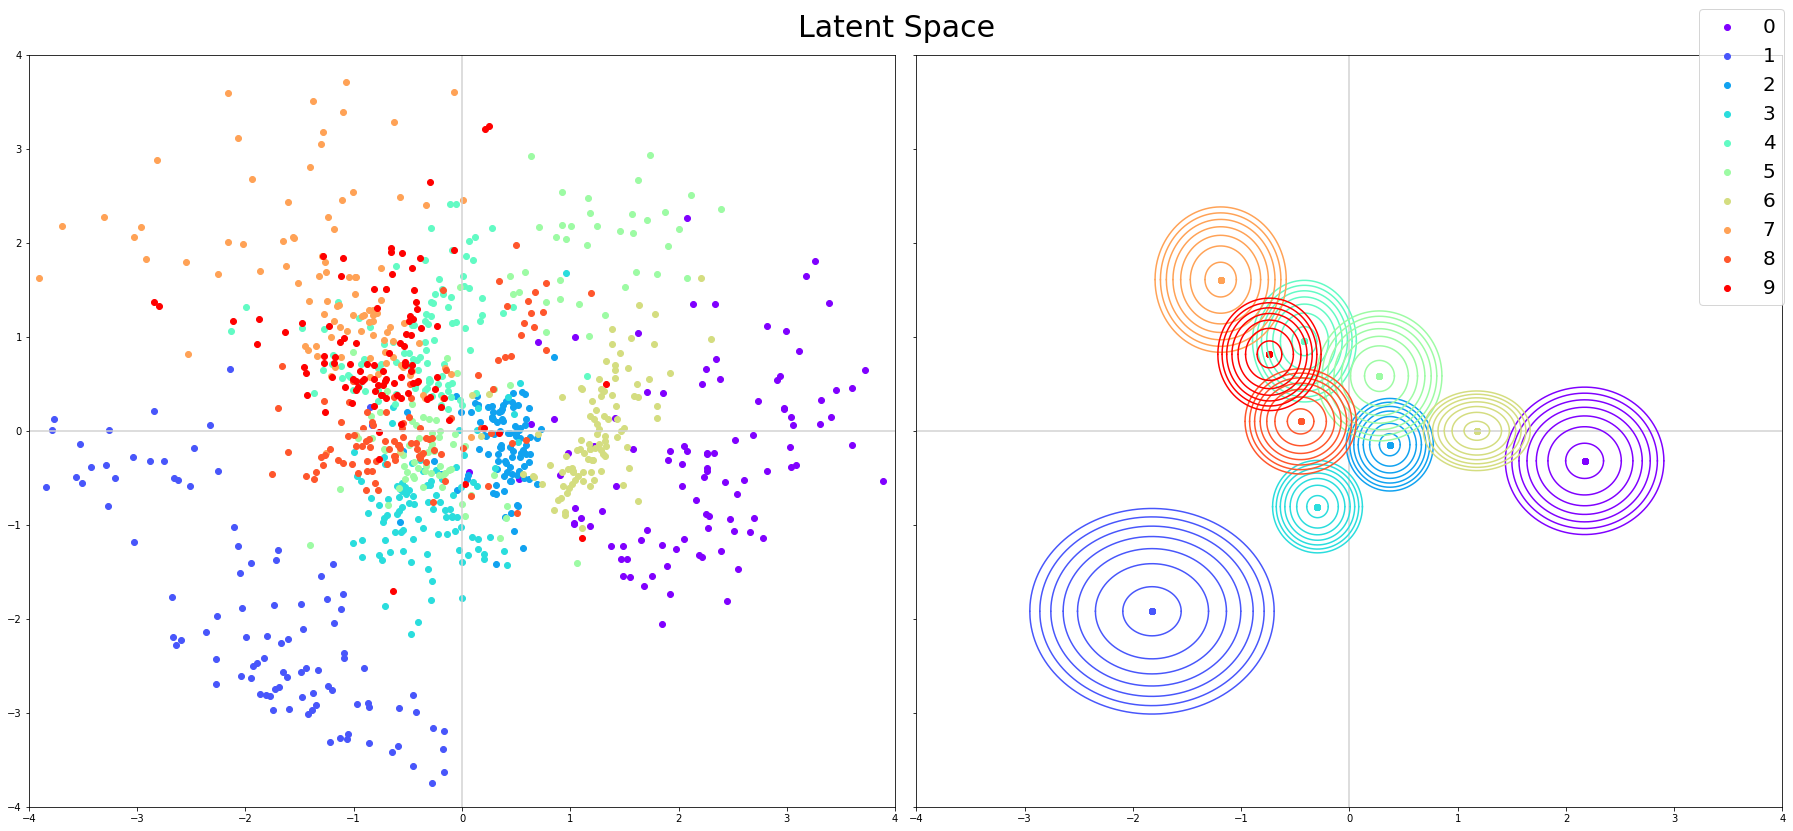

In [20]:
latent_space(vae, test_data, 100, 'test_latent_space.png')

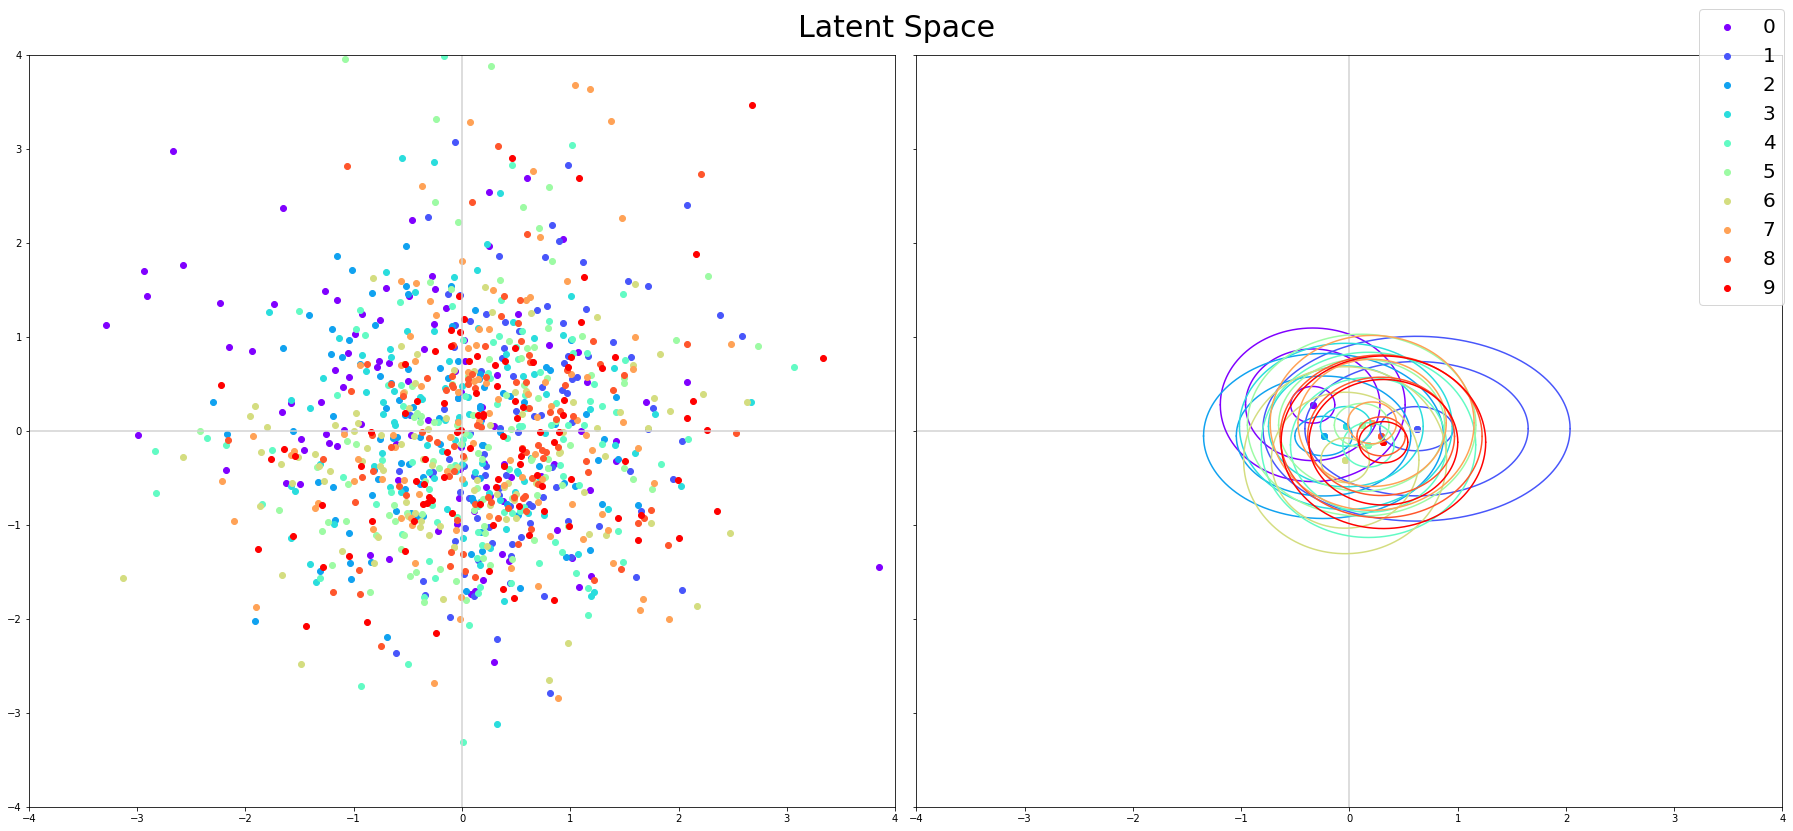

In [21]:
latent_space(cvae, train_data, 100, 'train_conditional_latent_space.png', n_contours=3)

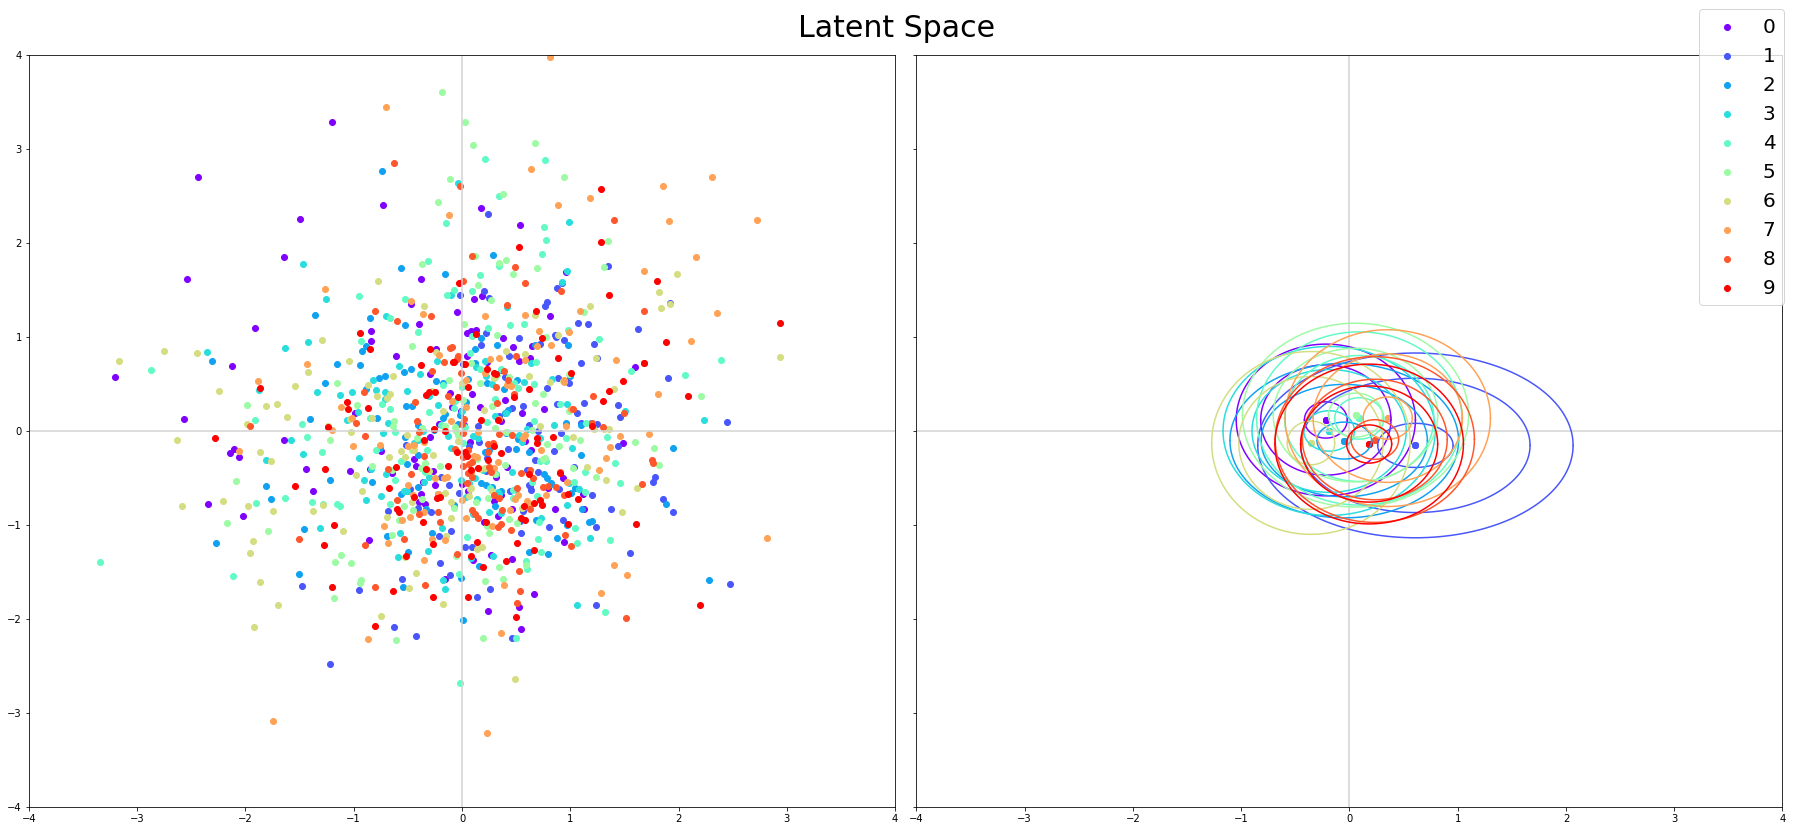

In [22]:
latent_space(cvae, test_data, 100, 'test_conditional_latent_space.png', n_contours=3)

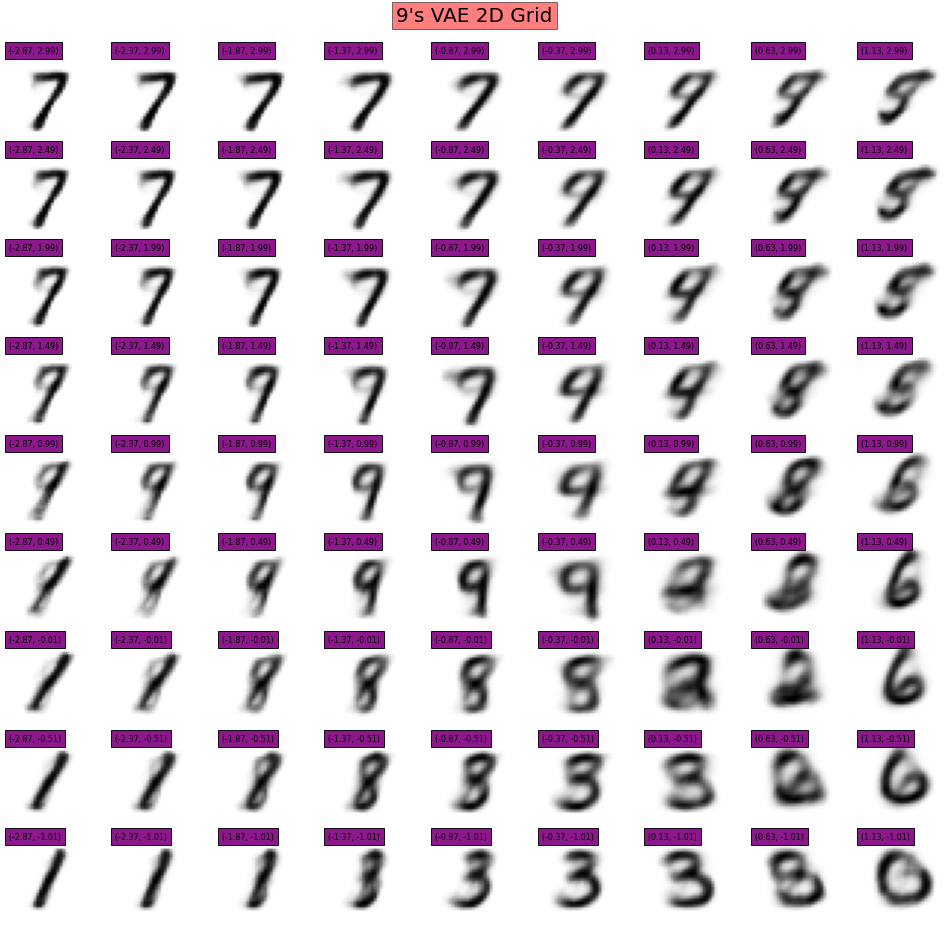

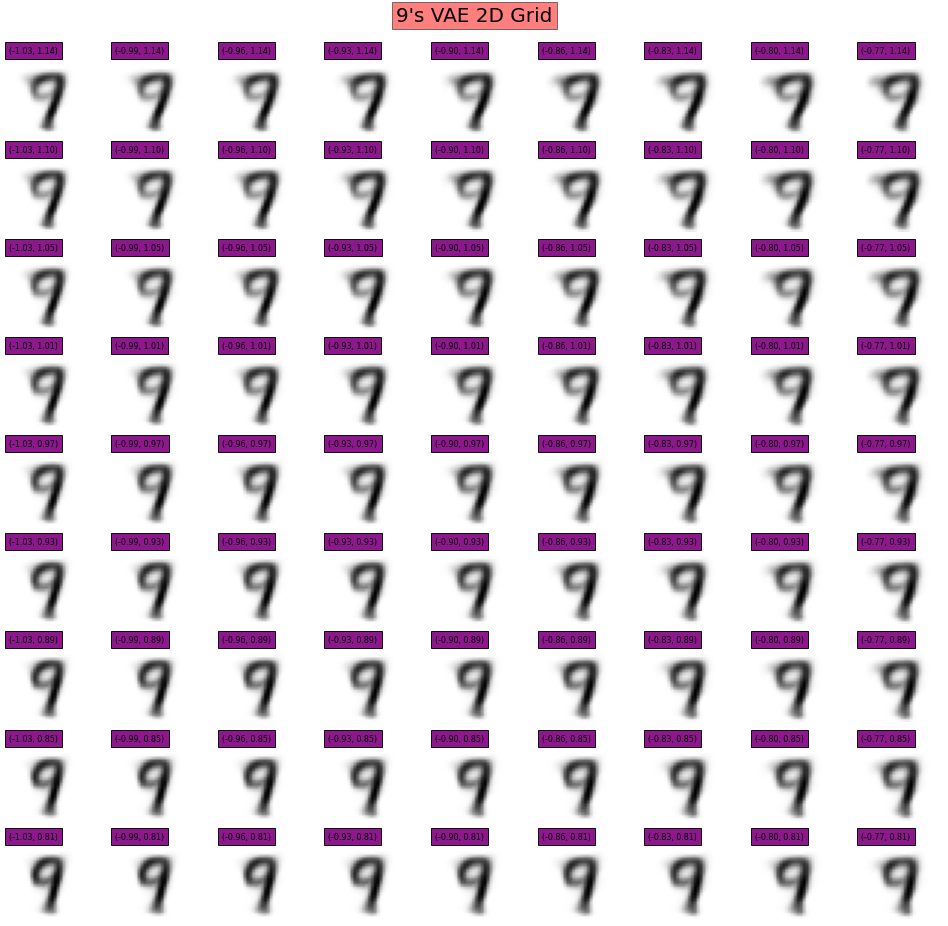

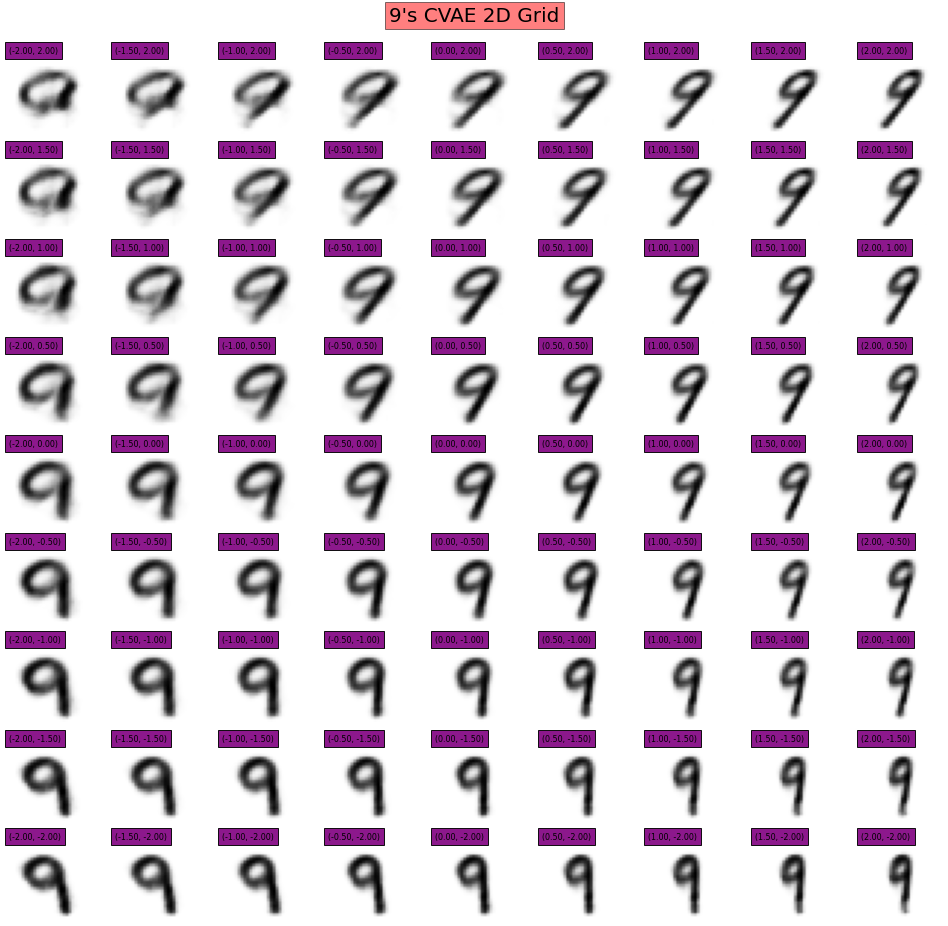

In [37]:
digit_grid(vae, 9, train_data, filename='9vaegrid.png')
digit_grid(vae, 9, train_data, normalize=True)
digit_grid(cvae, 9, train_data, filename='9cvaegrid.png')

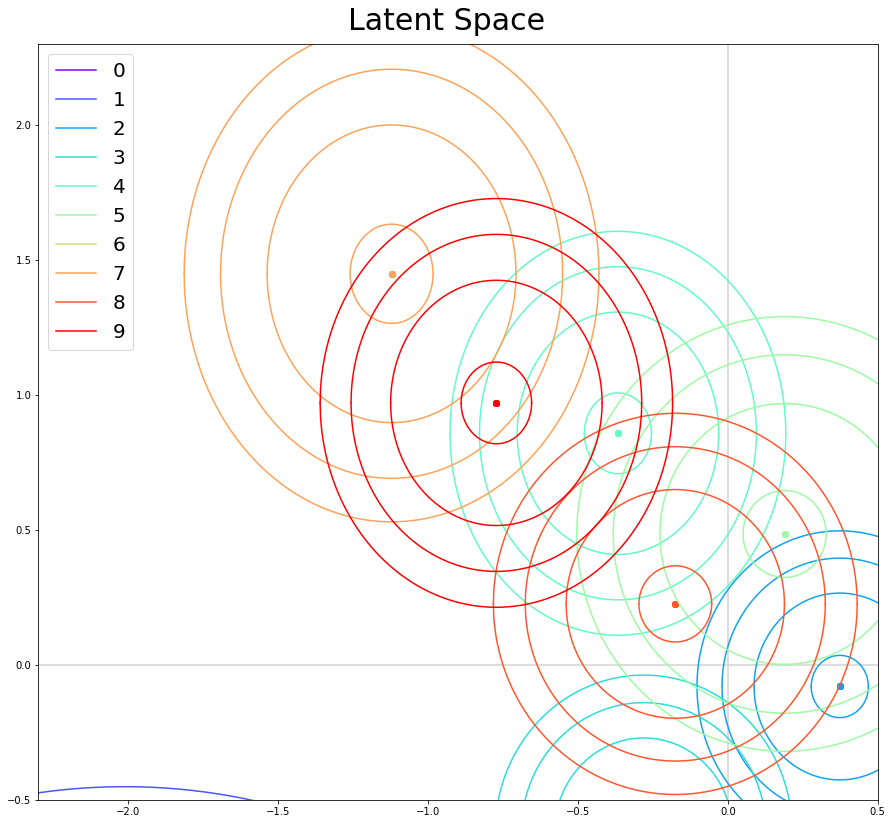

In [38]:
latent_space(vae, train_data, 100, maxC=100, n_contours=4, xmin=-2.3, xmax=0.5, ymin=-0.5, ymax=2.3, scatter=False, filename='train-latent-focus-9.png')

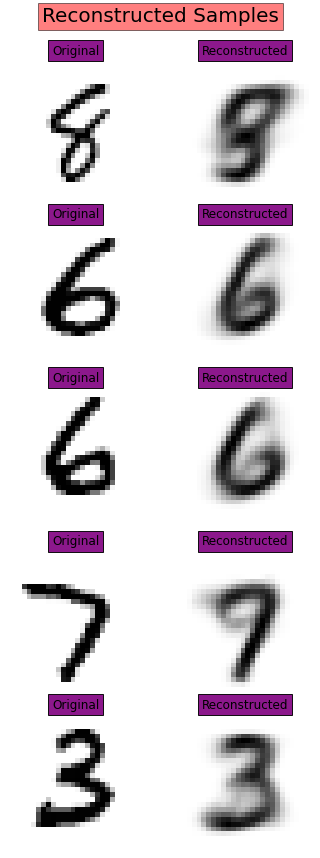

In [26]:
visual_eval(vae, test_data, generations=0, reconstructions=5, filename='vae2_reconstructions.png')

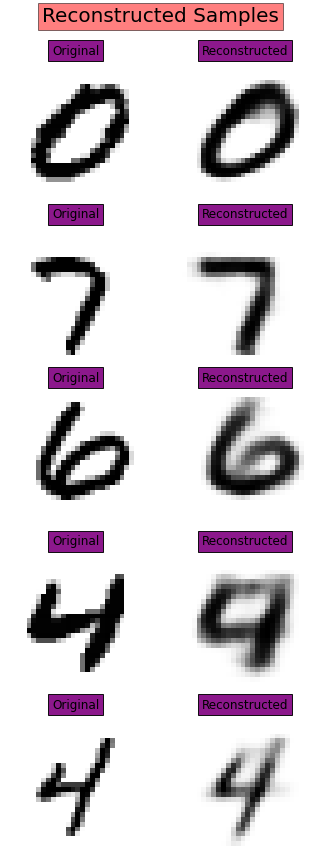

In [25]:
visual_eval(vae5, test_data, generations=0, reconstructions=5, filename='vae5_reconstructions.png')

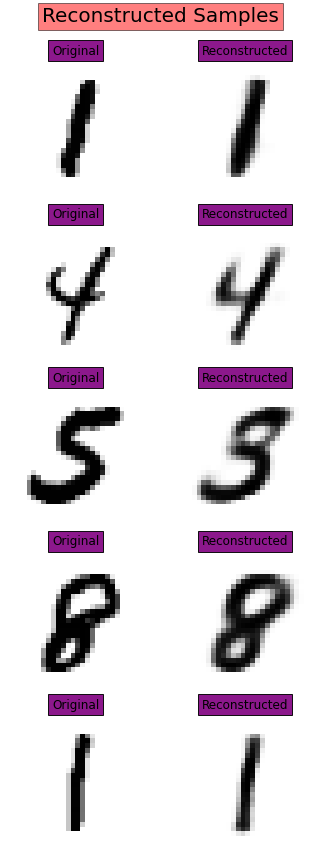

In [28]:
visual_eval(vae10, test_data, generations=0, reconstructions=5, filename='vae10_reconstructions.png')

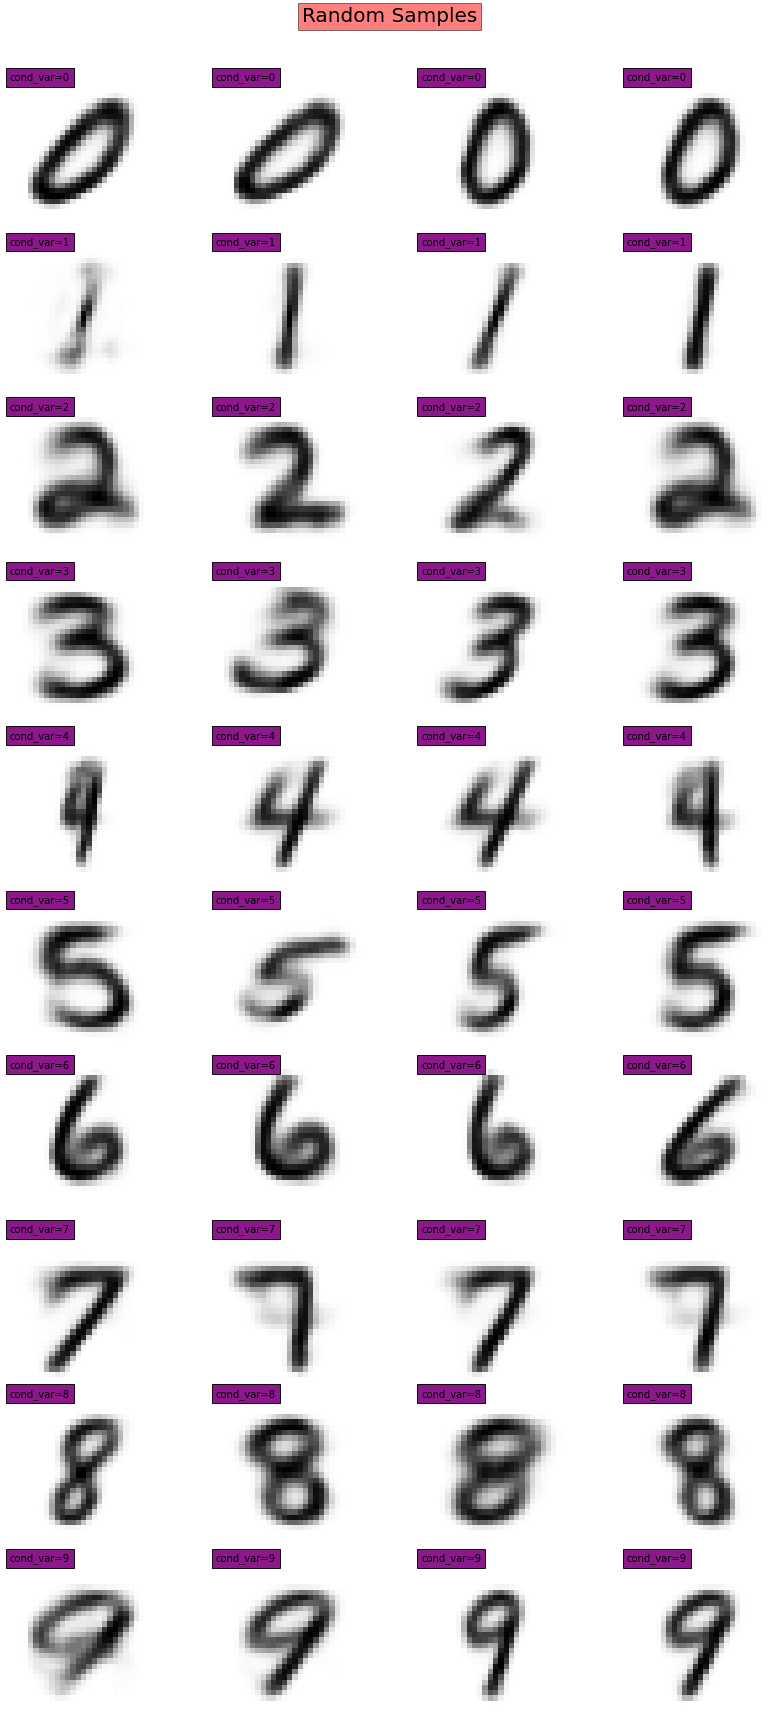

In [29]:
visual_eval(cvae, generations=40, per_row=4, reconstructions=0, filename='cvae2_samples.png')

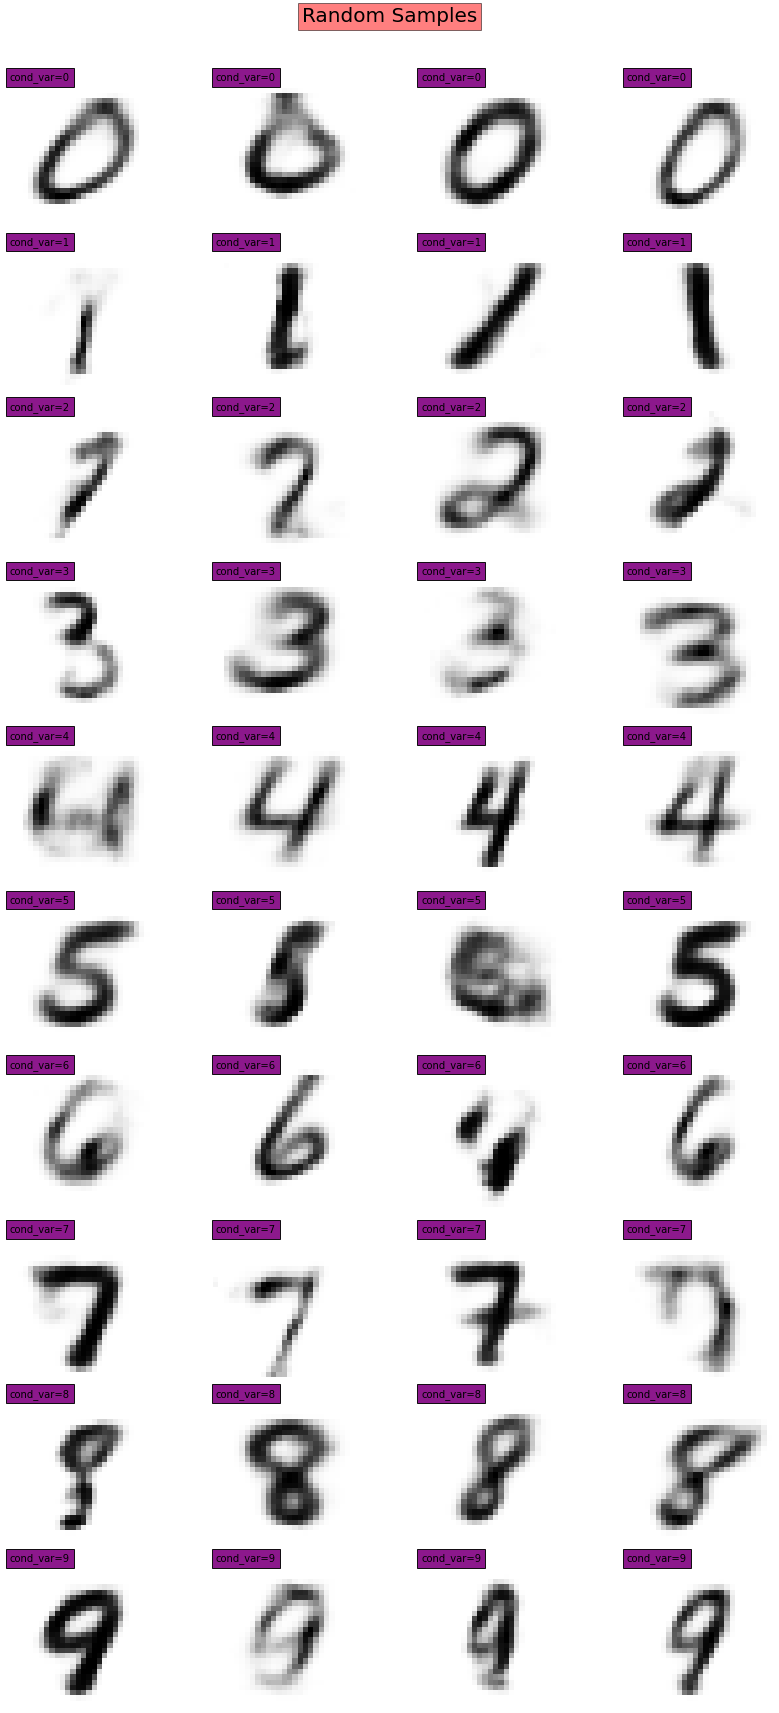

In [30]:
visual_eval(cvae5, generations=40, per_row=4, reconstructions=0, filename='cvae5_samples.png')